In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler


import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transform
from torchvision.transforms import ToTensor

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

import matplotlib.pyplot as plt
import glob
import os
import sys
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler

from PIL import Image

In [2]:
# We use CUDA if possible
cuda = torch.cuda.is_available()
print("CUDA is available:", cuda)
device = torch.device('cuda' if cuda else 'cpu')

CUDA is available: True


### First we create the dataset

Implementation made following https://github.com/adambielski/siamese-triplet

In [3]:
class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
    
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]
        
        if len(img1.shape) > 2:
            img1 = Image.fromarray(np.uint8(img1.permute(1, 2, 0).numpy() * 255))
            img2 = Image.fromarray(np.uint8(img2.permute(1, 2, 0).numpy() * 255))
        else:
            # In the case of the MNIST dataset image was already in range [0-255]
            img1 = Image.fromarray(img1.numpy(), mode='L')
            img2 = Image.fromarray(img2.numpy(), mode='L')
        
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        return (img1, img2), target

    def __len__(self):
        return len(self.mnist_dataset)
    
### HYPERPARAMETERS
train_set = 'MIT_SPLIT'

print('Training set is:', train_set)
root_dir = '../datasets/' + train_set

train_data_dir= root_dir + '/train'
val_data_dir= root_dir + '/test'
test_data_dir= root_dir + '/test'

img_width = 224
img_height=224


### CREATE DATASET
transformation_train = transform.Compose([
    # you can add other transformations in this list
    # transform.RandomRotation(90),
    # transform.RandomHorizontalFlip(),
    # transform.RandomVerticalFlip(),
    ToTensor()
])

# No need to use data augmentation in validation
transformation_val = transform.Compose([
    # you can add other transformations in this list
    ToTensor()
])

batch_size = 8

train_dataset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transformation_train)
valid_dataset = torchvision.datasets.ImageFolder(root=test_data_dir,  transform=transformation_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# We need to fill some attributes for the SiameseDataset class
train_dataset.train = True
valid_dataset.train = False

train_dataset.train_labels = torch.from_numpy(np.array(train_dataset.targets))
valid_dataset.test_labels = torch.from_numpy(np.array(valid_dataset.targets))

train_dataset.train_data = torch.from_numpy(np.array([s[0].numpy() for s in train_dataset]))
valid_dataset.test_data = torch.from_numpy(np.array([s[0].numpy() for s in valid_dataset]))


inv_class_to_idx = {v: k for k, v in train_dataset.class_to_idx.items()}

print(train_dataset.class_to_idx)
print(train_dataset.train_data.shape)
print(train_dataset.train_labels.shape)

siamese_train_dataset = SiameseDataset(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseDataset(valid_dataset)

siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False)

Training set is: MIT_SPLIT
{'Opencountry': 0, 'coast': 1, 'forest': 2, 'highway': 3, 'inside_city': 4, 'mountain': 5, 'street': 6, 'tallbuilding': 7}
torch.Size([1881, 3, 256, 256])
torch.Size([1881])


In [14]:
mnist_classes = train_dataset.classes
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

def plot_embeddings(embeddings, targets, title='', xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    plt.title(title)
    for i in range(8):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

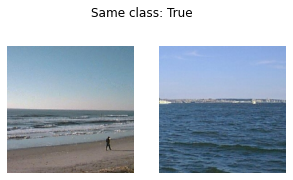

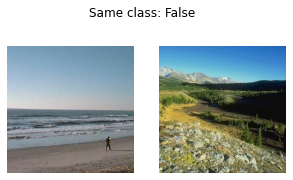

In [15]:
idx = 500
%matplotlib inline

(img1, img2), target = siamese_train_dataset[idx]
plt.figure(figsize=(5,3))
plt.suptitle(f'Same class: {target==1}')
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img1.permute(1, 2, 0).numpy())
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(img2.permute(1, 2, 0).numpy())
plt.show()

(img1, img2), target = siamese_train_dataset[idx]
plt.figure(figsize=(5,3))
plt.suptitle(f'Same class: {target==1}')
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img1.permute(1, 2, 0).numpy())
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(img2.permute(1, 2, 0).numpy())
plt.show()

### Now we create our Siamese Neural Network

In [7]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        # Change for one channel instead of 3 if input is grayscale
        self.convnet = nn.Sequential(nn.Conv2d(3, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(238144, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

In [8]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

In [9]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [10]:
margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [11]:
class Metric:
    def __init__(self):
        pass

    def __call__(self, outputs, target, loss):
        raise NotImplementedError

    def reset(self):
        raise NotImplementedError

    def value(self):
        raise NotImplementedError

    def name(self):
        raise NotImplementedError


class AccumulatedAccuracyMetric(Metric):
    """
    Works with classification model
    """

    def __init__(self):
        self.correct = 0
        self.total = 0

    def __call__(self, outputs, target, loss):
        pred = outputs[0].data.max(1, keepdim=True)[1]
        self.correct += pred.eq(target[0].data.view_as(pred)).cpu().sum()
        self.total += target[0].size(0)
        return self.value()

    def reset(self):
        self.correct = 0
        self.total = 0

    def value(self):
        return 100 * float(self.correct) / self.total

    def name(self):
        return 'Accuracy'

In [12]:
def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[],
        start_epoch=0):
    """
    Loaders, model, loss function and metrics should work together for a given task,
    i.e. The model should be able to process data output of loaders,
    loss function should process target output of loaders and outputs from the model
    Examples: Classification: batch loader, classification model, NLL loss, accuracy metric
    Siamese network: Siamese loader, siamese model, contrastive loss
    Online triplet learning: batch loader, embedding model, online triplet loss
    """
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        scheduler.step()

        # Train stage
        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
        val_loss /= len(val_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        print(message)


def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()

    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()


        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics


def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics

fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

c:\Users\Marcos\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/1881 (0%)]	Loss: 0.308199
Train: [800/1881 (42%)]	Loss: 0.150498
Train: [1600/1881 (85%)]	Loss: 0.131203
Epoch: 1/20. Train set: Average loss: 0.1412
Epoch: 1/20. Validation set: Average loss: 0.1360
Train: [0/1881 (0%)]	Loss: 0.129030
Train: [800/1881 (42%)]	Loss: 0.135713
Train: [1600/1881 (85%)]	Loss: 0.129707
Epoch: 2/20. Train set: Average loss: 0.1294
Epoch: 2/20. Validation set: Average loss: 0.1215
Train: [0/1881 (0%)]	Loss: 0.056683
Train: [800/1881 (42%)]	Loss: 0.117486
Train: [1600/1881 (85%)]	Loss: 0.117981
Epoch: 3/20. Train set: Average loss: 0.1152
Epoch: 3/20. Validation set: Average loss: 0.1231
Train: [0/1881 (0%)]	Loss: 0.142670
Train: [800/1881 (42%)]	Loss: 0.108906
Train: [1600/1881 (85%)]	Loss: 0.112627
Epoch: 4/20. Train set: Average loss: 0.1109
Epoch: 4/20. Validation set: Average loss: 0.1095
Train: [0/1881 (0%)]	Loss: 0.126973
Train: [800/1881 (42%)]	Loss: 0.113838
Train: [1600/1881 (85%)]	Loss: 0.105387
Epoch: 5/20. Train set: Average loss: 0.1081


In [16]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl, title='Train embeddings')
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl, title='Test embeddings')

In [ ]:
sys.exit()

SystemExit: 